In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
sns.set()

In [2]:
data  = pd.read_csv('hypothyroid.csv')


In [3]:
# import matplotlib.pyplot as plt
# for i in range data[column]:
#     fig ,ax  = plt.subplots(figsize = (20,20))
#     sns.boxplot(data = data , ax = ax)

In [4]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [5]:
data.shape

(3772, 30)

In [6]:
# from pandas_profiling  import ProfileReport
# pf = ProfileReport(data)
# pf
# #data.describe()

We can see from the data description that there are no missing values. But if you check the dataset the missing values are replaced with invalid values like '?'. Let's replace such values with 'nan' and check for missing values again.

In [7]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        print(column, data[column][data[column]=='?'].count())
    

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values. 

Also, we can see thatfor column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

In [8]:
data = data.drop(['TBG'],axis =1)

Also, looking to the dataset, we can see that some columns are with true and false value are just the indication that whether the next column has values or not. Let's see an example:

In [9]:
data[['T4U_measured','T4U']] 

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


Since, we are any ways going to handle the missing values, there is no point of having such columns in our dataset.

Let's drop such columns as well.

In [10]:
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured' ],axis =1)

In [11]:
# Now let's replace the '?' values with numpy nan
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        data[column] = data[column].replace('?',np.nan)    

In [12]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count==0:
        print(column, data[column][data[column]=='?'].count())    

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


Great!! Now that we have replaced all such values with 'nan'. Let's deal with these missing values now.

In [13]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

Since the values are categorical, we have to change them to numerical before we use any imputation techniques.

We can use get dummies but since most of the columns have only two distinct categories we will use mapping for them. Why? Because since there are only two categories then the two columns formed after get dummies will both have very high correaltion since they both explain the same thing. So in anyway we will have to drop one of the columns. That's why let's use mapping for such columns.
For columns with more than two categories we will use get dummies.

In [14]:
# We can map the categorical values like below:
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, let's do a smarter work
for column in data.columns:
    if  len(data[column].unique())==2:
        data[column] = data[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories. 


In [15]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1.3,2.5,125,1.14,109,SVHC,negative
1,23,0.0,0,0,0,0,0,0,0,0,...,0,0,0,4.1,2,102,NaN,NaN,other,negative
2,46,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109,0.91,120,other,negative
3,70,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175,NaN,NaN,other,negative
4,70,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61,0.87,70,SVI,negative


In [16]:
data['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [17]:
# we will use get_dummies with that.
data = pd.get_dummies(data, columns=['referral_source'])
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,negative,0,1,0,0,0
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,negative,0,0,0,0,1
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,negative,0,0,0,0,1
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,negative,0,0,0,0,1
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,negative,0,0,0,1,0


Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them.
Let's use LabelEncoder function for this.

In [18]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [19]:
lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [20]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,1,0,1,0,0,0
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,1,0,0,0,0,1
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,1,0,0,0,0,1
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,1,0,0,0,0,1
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,1,0,0,0,1,0


In [21]:
data.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3003,3541,3385,3387,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69,241,146,234,NaN,NaN,NaN,NaN,NaN,NaN
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,101,0.99,100,NaN,NaN,NaN,NaN,NaN,NaN
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238,71,95,73,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000


Great! Now that we have encoded all our Categorical values. Let's start with imputing the missing values.

In [22]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(data) # impute the missing values
    # convert the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=data.columns)

In [23]:
new_data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.737275,0.307529,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,2.026776,108.459438,1.020944,110.301166,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,20.082478,0.461532,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,0.785086,34.838114,0.165546,32.145618,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# pf = ProfileReport(new_data)
# pf

In [25]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Great! Now there are no missing values in our new dataset. 


Let's check the distribution for our continous data in the dataset:

C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

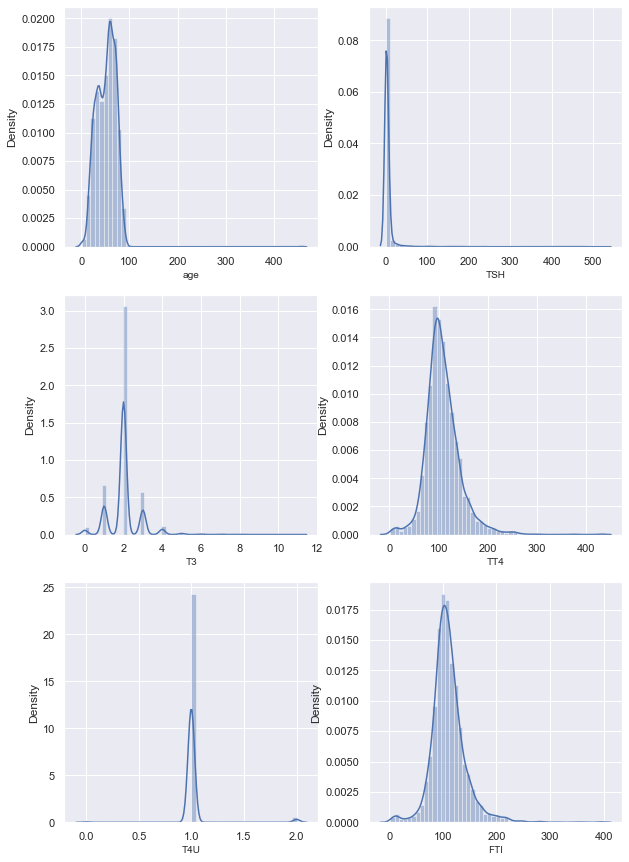

In [26]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(new_data[column])
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

The graphs for age, TSH and T3 looks heavely skewed towards left. Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\envs\new_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

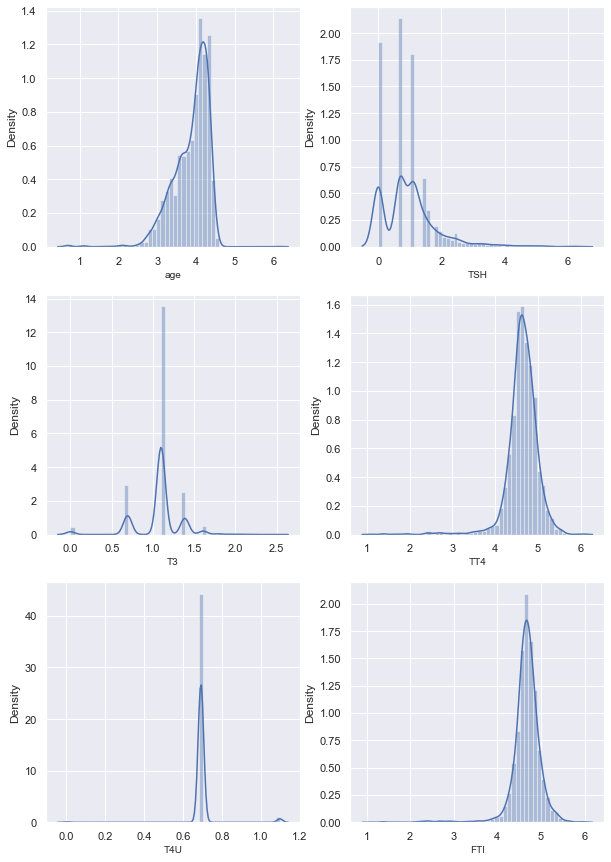

In [27]:
#After log transformation 
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_data[column]))
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()




In [28]:
#'TSH' column giving us weird trend. It won't give much of information so let's drop this column
new_data = new_data.drop(['TSH'],axis=1)


#### let's see how balanced our dataset in terms of given target classes:

C:\Anaconda\envs\new_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

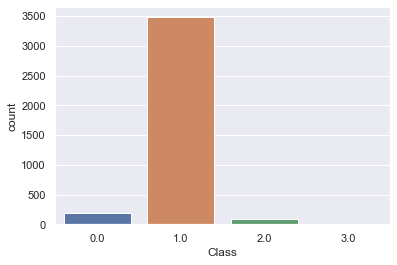

In [29]:
# let's see how data is distributed for every column for every individual id
# the graph plot below is for individual ids. Press 1 in the  input box below the graph to continue viewing graph for each id!!



sns.countplot(new_data['Class'])
        
    

We can clerly see that the dataset is highly imbalanced. 

We will use a python library known as imbalanced-learn to deal with imbalanced data.
Imbalanced learn has an algorithm called RandomOverSampler. 

In [30]:
# cat = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# sm = SMOTENC(categorical_features = cat,sampling_strategy='minority',k_neighbors=3)

In [31]:
# kmsmote=KMeansSMOTE()
from imblearn.over_sampling import RandomOverSampler

In [32]:
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)

In [33]:
# x_sampled,y_sampled = kmsmote.fit_sample(x,np.asarray(y))

In [34]:
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)

In [35]:
x_sampled.shape

(13924, 25)

In [36]:
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)

In [37]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0


C:\Anaconda\envs\new_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

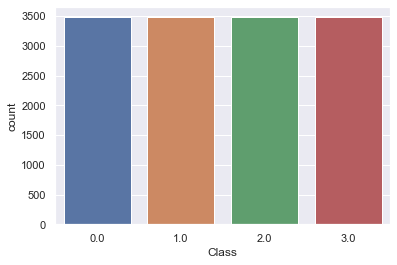

In [38]:
sns.countplot(y_sampled)       
    

# Model *Building*

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [40]:
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0


In [41]:
from sklearn.cluster import KMeans



In [42]:
def elbow_plot(data):
        wcss=[] # initializing an empty list
        try:
            for i in range (1,11):
                kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
                kmeans.fit(data) # fitting the data to the KMeans Algorithm
                wcss.append(kmeans.inertia_)
            plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
            plt.title('The Elbow Method')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')

            plt.savefig('K-Means_Elbow.PNG') # saving the elbow plot locally
            # finding the value of the optimum cluster programmatically
            kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
            print('The optimum number of clusters is: '+str(kn.knee)+' . Exited the elbow_plot method of the KMeansClustering class')
            return kn.knee

        except Exception as e:
            print(e)

name 'KneeLocator' is not defined


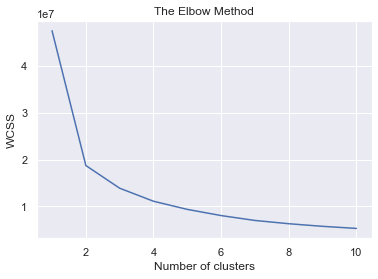

In [43]:
elbow_plot(x_sampled)

In [44]:
def create_clusters(data,number_of_clusters):

        
        try:
            kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
            
            y_kmeans=kmeans.fit_predict(data) #  divide data into clusters


            data['Cluster']=y_kmeans  # create a new column in dataset for storing the cluster information
            print('succesfully created '+str(f"{number_of_clusters}")+ ' clusters. Exited the create_clusters method of the KMeansClustering class')
            return data

        except Exception as e:
            print(e)
        

In [45]:
x_sampled = create_clusters(x_sampled,3)

succesfully created 3 clusters. Exited the create_clusters method of the KMeansClustering class


In [46]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,2
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,1
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1


In [47]:
#Adding data labels into x
x_sampled['Labels']=y_sampled

In [48]:
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster,Labels
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,0,1.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,2,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,2,1.0


In [49]:
list_of_clusters=x_sampled['Cluster'].unique()
list_of_clusters

array([0, 2, 1])

# Model on Cluster == 1

In [50]:
cluster_data=x_sampled[x_sampled['Cluster']==1]

In [51]:
cluster_data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster,Labels
40,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,2.0,34.0,0.0,0.0,0.0,1.0,0.0,1,2.0
88,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,2.0,10.0,0.0,0.0,0.0,0.0,1.0,1,2.0
89,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,2.0,61.0,0.0,0.0,0.0,1.0,0.0,1,1.0
91,81.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,2.0,42.0,0.0,0.0,0.0,1.0,0.0,1,1.0
116,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,2.0,29.0,0.0,0.0,0.0,0.0,1.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1,3.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,1,3.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1,3.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,1,3.0


In [52]:
cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
cluster_label= cluster_data['Labels']

In [53]:
# splitting the data into training and test set for each cluster one by one
x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=355)

In [54]:
x_train

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
7519,61.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,12.0,2.0,10.0,0.0,0.0,0.0,0.0,1.0
11818,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
11091,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
8946,29.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,66.0,2.0,57.0,0.0,0.0,0.0,1.0,0.0
12008,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13508,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
9089,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,18.0,2.0,16.0,0.0,0.0,0.0,1.0,0.0
10527,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0


In [55]:
y_train

7519     2.0
11818    3.0
11091    3.0
8946     2.0
12008    3.0
        ... 
11094    3.0
13508    3.0
9089     2.0
10527    3.0
9731     2.0
Name: Labels, Length: 4543, dtype: float64

In [56]:
def get_best_params_for_xgboost(train_x,train_y):
        print('Entered the get_best_params_for_xgboost method of the Model_Finder class')
        try:
            
            # initializing with different combination of parameters
            param_grid_xgboost = {

                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [3, 5, 10, 20],
                'n_estimators': [10, 50, 100, 200]

            }
            # Creating an object of the Grid Search class
            grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid_xgboost, verbose=3,cv=5)
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            learning_rate = grid.best_params_['learning_rate']
            max_depth = grid.best_params_['max_depth']
            n_estimators = grid.best_params_['n_estimators']

            # creating a new model with the best parameters
            xgb = XGBClassifier(learning_rate=1, max_depth=5, n_estimators=50)
            # training the mew model
            xgb.fit(train_x, train_y)
            return xgb
        except Exception as e:
            raise Exception()


In [57]:
xgb_classifier = get_best_params_for_xgboost(x_train,y_train)

Entered the get_best_params_for_xgboost method of the Model_Finder class
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.993 total time=   0.0s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.994 total time=   0.0s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.997 total time=   0.0s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.999 total time=   0.0s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.993 total time=   0.0s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.996 total time=   0.1s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.997 total time=   0.1s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.998 total time=   0.1s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=50;, score=1.000 total time=   0.1s
[CV 5/5] END learni

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.994 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.994 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.997 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.999 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.993 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.994 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.994 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.997 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=1.000 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.994 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimato

[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.997 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.992 total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.992 total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.993 total time=   1.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.992 total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.997 total time=   0.9s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.992 total time=   1.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.992 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth

[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.992 total time=   1.1s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.992 total time=   0.8s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=10;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=10;, score=0.998 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=10;, score=0.992 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.994 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.993 total time=   0.3s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.996 total time=   0.3s
[CV 4/5] END learning_rate=0.001, max_

In [58]:
def get_best_params_for_KNN(train_x, train_y):
       
        print('Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class')
        try:
            #initializing with different combination of parameters
            param_grid_knn = {
                'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                'leaf_size' : [10,17,24,28,30,35],
                'n_neighbors':[4,5,8,10,11],
                'p':[1,2]
            }

            knn = KNeighborsClassifier()
            #Creating an object of the Grid Search class
            grid = GridSearchCV(knn, param_grid_knn, verbose=3,cv=5)
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            algorithm =grid.best_params_['algorithm']
            leaf_size = grid.best_params_['leaf_size']
            n_neighbors = grid.best_params_['n_neighbors']
            p  = grid.best_params_['p']

            # creating a new model with the best parameters
            knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors,p=p,n_jobs=-1)
            # training the mew model
            knn.fit(train_x, train_y)
            print('KNN best params: ' + str(f"{grid.best_params_}") + '. Exited the KNN method of the Model_Finder class')
            return knn

        except Exception as e:
            raise Exception()

In [59]:
knn_classifier = get_best_params_for_KNN(x_train, y_train)

Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbor

[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.993 total tim

[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.1s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.1s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.992 total time=   0.2s


[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.1s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.994 total time=   0.0

[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.994 total time=   0.1s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.1s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=1;, score=0.994 total time=   0.0s
[CV 3/5] E

[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorit

[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorit

[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.991 total time=   0.0s
[CV 5/5] E

[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.992 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.994 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.992 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=

[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.992 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.993 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=

[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.987 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.2s
[CV 3/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.2s
[CV 4/5] END algorithm=brute, lea

In [60]:
def get_best_params_for_random_forest(train_x,train_y):
        """
                                Method Name: get_best_params_for_random_forest
                                Description: get the parameters for Random Forest Algorithm which give the best accuracy.
                                             Use Hyper Parameter Tuning.
                                Output: The model with the best parameters
                                On Failure: Raise Exception

        """
        print('Entered the get_best_params_for_random_forest method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}

            clf = RandomForestClassifier()
        
            #Creating an object of the Grid Search class
            grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            criterion = grid.best_params_['criterion']
            max_depth = grid.best_params_['max_depth']
            max_features = grid.best_params_['max_features']
            n_estimators = grid.best_params_['n_estimators']

            #creating a new model with the best parameters
            clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                              max_depth=max_depth, max_features=max_features)
            # training the mew model
            clf.fit(train_x, train_y)
            
            print('Random Forest best params: '+str(f"{grid.best_params_}")+'. Exited the get_best_params_for_random_forest method of the Model_Finder class')

            return clf
        except Exception as e:
            raise Exception()


In [61]:
random_forest_classifier = get_best_params_for_random_forest(x_train,y_train)

Entered the get_best_params_for_random_forest method of the Model_Finder class
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.964 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.968 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.960 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.937 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.937 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.933 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.963 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.96

[CV 4/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100;, score=0.967 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100;, score=0.974 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.968 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.974 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.970 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.967 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.974 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=10;, score=0.953 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=10;, score=0.970 total time=   0.

[CV 3/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=50;, score=0.970 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=50;, score=0.968 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=50;, score=0.975 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.972 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.974 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.970 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.968 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.974 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=130;, score=0.

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

def get_best_params_for_naive_bayes(train_x,train_y):
        gnb = GaussianNB()
        print( 'Entered the get_best_params_for_naive_bayes method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            param_grid = {"var_smoothing": [1e-9,0.1, 0.001, 0.5,0.05,0.01,1e-8,1e-7,1e-6,1e-10,1e-11]}

            #Creating an object of the Grid Search class
            grid = GridSearchCV(estimator=gnb , param_grid=param_grid, cv=3,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            var_smoothing = grid.best_params_['var_smoothing']


            #creating a new model with the best parameters
            gnb = GaussianNB(var_smoothing=var_smoothing)
            # training the mew model
            gnb.fit(train_x, train_y)
            print('Naive Bayes best params: '+str(grid.best_params_)+'. Exited the get_best_params_for_naive_bayes method of the Model_Finder class')

            return gnb
        except Exception as e:
            raise Exception()
            
                       

In [63]:
naive_bayes =get_best_params_for_naive_bayes(x_train,y_train)

Entered the get_best_params_for_naive_bayes method of the Model_Finder class
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV 1/3] END ...............var_smoothing=1e-09;, score=0.838 total time=   0.0s
[CV 2/3] END ...............var_smoothing=1e-09;, score=0.840 total time=   0.0s
[CV 3/3] END ...............var_smoothing=1e-09;, score=0.847 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.1;, score=0.903 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.1;, score=0.907 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.1;, score=0.903 total time=   0.0s
[CV 1/3] END ...............var_smoothing=0.001;, score=0.964 total time=   0.0s
[CV 2/3] END ...............var_smoothing=0.001;, score=0.971 total time=   0.0s
[CV 3/3] END ...............var_smoothing=0.001;, score=0.972 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.5;, score=0.827 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.5;, sc

In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def get_best_params_for_svm(train_x,train_y):
        sv_classifier=SVC()

        print('Entered the get_best_params_for_svm method of the Model_Finder class')
        try:
            
            # initializing with different combination of parameters
            param_grid = {"kernel": ['rbf', 'sigmoid'],
                          "C": [0.1, 0.5, 1.0],
                          "random_state": [0, 100, 200, 300]}

            #Creating an object of the Grid Search class
            grid = GridSearchCV(estimator=sv_classifier, param_grid=param_grid, cv=5,  verbose=3)
            #finding the best parameters
            grid.fit(train_x, train_y)

            #extracting the best parameters
            kernel = grid.best_params_['kernel']
            C = grid.best_params_['C']
            random_state = grid.best_params_['random_state']


            #creating a new model with the best parameters
            sv_classifier = SVC(kernel=kernel,C=C,random_state=random_state)
            # training the mew model
            sv_classifier.fit(train_x, train_y)
            print('SVM best params: '+str(grid.best_params_)+'. Exited the get_best_params_for_svm method of the Model_Finder class')

            return sv_classifier
        except Exception as e:
            raise Exception()

In [65]:
svc_classifier= get_best_params_for_svm(x_train,y_train)

Entered the get_best_params_for_svm method of the Model_Finder class
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.877 total time=   0.5s
[CV 2/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.889 total time=   0.5s
[CV 3/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.886 total time=   0.5s
[CV 4/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.876 total time=   0.5s
[CV 5/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.911 total time=   0.6s
[CV 1/5] END C=0.1, kernel=rbf, random_state=100;, score=0.877 total time=   0.5s
[CV 2/5] END C=0.1, kernel=rbf, random_state=100;, score=0.889 total time=   0.5s
[CV 3/5] END C=0.1, kernel=rbf, random_state=100;, score=0.886 total time=   0.5s
[CV 4/5] END C=0.1, kernel=rbf, random_state=100;, score=0.876 total time=   0.5s
[CV 5/5] END C=0.1, kernel=rbf, random_state=100;, score=0.911 total time=   0.5s
[CV 1/5] END C=0.1, kernel=rbf, random_state=200;, sco

[CV 3/5] END C=1.0, kernel=rbf, random_state=300;, score=0.958 total time=   0.2s
[CV 4/5] END C=1.0, kernel=rbf, random_state=300;, score=0.953 total time=   0.3s
[CV 5/5] END C=1.0, kernel=rbf, random_state=300;, score=0.965 total time=   0.2s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.815 total time=   0.5s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.851 total time=   0.6s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.828 total time=   0.5s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.823 total time=   0.5s
[CV 5/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.837 total time=   0.5s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.815 total time=   0.5s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.851 total time=   0.5s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.828 total time=   0.5s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.823 total tim

In [66]:
def get_best_model(train_x,train_y,test_x,test_y):
     
        print('Entered the get_best_model method of the Model_Finder class')
        # create best model for KNN
        try:
            knn= get_best_params_for_KNN(train_x,train_y)
            prediction_knn = knn.predict_proba(test_x) # Predictions using the KNN Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                knn_score = accuracy_score(test_y, prediction_knn)
                print('Accuracy for knn:' + str(knn_score))  # Log AUC
            else:
                knn_score = roc_auc_score(test_y, prediction_knn, multi_class='ovr') # AUC for KNN
                print('AUC for knn:' + str(knn_score)) # Log AUC

            # create best model for XG BOOST
            xg_boost= get_best_params_for_xgboost(train_x,train_y)
            prediction_xg_boost=xg_boost.predict_proba(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                xg_boost_score = accuracy_score((test_y),prediction_xg_boost)
                print('Accuracy for xg_boost:' + str(xg_boost_score))
            else:
                xg_boost_score = roc_auc_score((test_y), prediction_xg_boost,multi_class='ovr') # AUC for XG BOOST
                print('AUC for xg_boost:' + str(xg_boost_score))

            #comparing the two models
            if(xg_boost_score <  knn_score):
                return 'KNN', knn
            else:
                return 'XGBOOST', xg_boost
  
        except Exception as e:
            print('Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(e))
            print('Model Selection Failed. Exited the get_best_model method of the Model_Finder class')

            raise Exception()

In [67]:
best_model_name,best_model= get_best_model(x_train,y_train,x_test,y_test)

Entered the get_best_model method of the Model_Finder class
Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.994 total time=   0.0

[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.994 total tim

[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=1;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.991 total time=   0.0s


[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.

[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] E

[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.2s
[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorit

[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorit

[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.991 total time=   0.0s
[CV 5/5] E

[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.992 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.994 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=

[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.993 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.992 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.993 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=

[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.992 total time=   0.2s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.991 total time=   0.2s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.992 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.987 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.1s
[CV 3/5] END algorithm=brute, le

[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.996 total time=   0.2s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.997 total time=   0.2s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.998 total time=   0.3s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.999 total time=   0.2s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.994 total time=   0.2s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.996 total time=   0.4s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.997 total time=   0.5s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.998 total time=   0.5s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.999 total time=   0.4s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.994 total time=   0.5s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimato

[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.997 total time=   0.7s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.999 total time=   0.8s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.994 total time=   0.7s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.996 total time=   1.4s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.997 total time=   1.5s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.998 total time=   1.5s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.999 total time=   1.3s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.994 total time=   1.6s
[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=10, n_es

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.999 total time=   1.5s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.993 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=10;, score=0.994 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=10;, score=0.993 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=10, n_estimators=10;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=10, n_estimators=10;, score=0.998 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=10;, score=0.992 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.994 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.994 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.996 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_dep

[CV 4/5] END learning_rate=0.001, max_depth=10, n_estimators=10;, score=0.998 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=10, n_estimators=10;, score=0.992 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=10, n_estimators=50;, score=0.994 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=10, n_estimators=50;, score=0.993 total time=   0.3s
[CV 3/5] END learning_rate=0.001, max_depth=10, n_estimators=50;, score=0.996 total time=   0.3s
[CV 4/5] END learning_rate=0.001, max_depth=10, n_estimators=50;, score=0.998 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=10, n_estimators=50;, score=0.992 total time=   0.3s
[CV 1/5] END learning_rate=0.001, max_depth=10, n_estimators=100;, score=0.994 total time=   0.7s
[CV 2/5] END learning_rate=0.001, max_depth=10, n_estimators=100;, score=0.993 total time=   0.8s
[CV 3/5] END learning_rate=0.001, max_depth=10, n_estimators=100;, score=0.996 total time=   0.7s
[CV 4/5] END learning_rate=

In [68]:
best_model_name 

'XGBOOST'

In [69]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [70]:
best_model.score(x_test,y_test)

0.9960387323943662

In [71]:
def get_best_model(train_x,train_y,test_x,test_y):
       
        print('Entered the get_best_model method of the Model_Finder class')
        # create best model for KNN
        try:
            knn= get_best_params_for_KNN(train_x,train_y)
            prediction_knn = knn.predict_proba(test_x) # Predictions using the KNN Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                knn_score = accuracy_score(test_y, prediction_knn)
                print('Accuracy for knn:' + str(knn_score))  # Log AUC
            else:
                knn_score = roc_auc_score(test_y, prediction_knn, multi_class='ovr') # AUC for KNN
                print('AUC for knn:' + str(knn_score)) # Log AUC

            
          
 # create best model for Random Forest
            random_forest= get_best_params_for_random_forest(train_x,train_y)
            prediction_random_forest=random_forest.predict_proba(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                random_forest_score = accuracy_score((test_y),prediction_random_forest)
                print('Accuracy for RF:' + str(random_forest_score))
            else:
                random_forest_score = roc_auc_score((test_y), prediction_random_forest,multi_class='ovr') # AUC for Random Forest
                print('AUC for RF:' + str(random_forest_score))

            #comparing the two models
            if(random_forest_score <  knn_score):
                return 'KNN', knn
            else:
                return 'RandomForest', random_forest
  
        except Exception as e:
            print('Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(e))
            print('Model Selection Failed. Exited the get_best_model method of the Model_Finder class')

            raise Exception()

In [72]:
best_model_name1,best_model1= get_best_model(x_train,y_train,x_test,y_test)

Entered the get_best_model method of the Model_Finder class
Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.994 total time=   0.0

[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total tim

[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=1;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.991 total time=   0.0s


[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.

[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] E

[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorit

[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.996 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorit

[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.993 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.991 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.987 total time=   0.0s
[CV 2/5] E

[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.994 total time=   0.3s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.993 total time=   0.2s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.991 total time=   0.2s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=1;, score=0.992 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.993 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.992 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size

[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=4, p=2;, score=0.994 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.992 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.994 total time=   0.2s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.993 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.993 total time=   0.2s
[CV 2/5] END algorithm=brute, leaf_size=

[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.992 total time=   0.2s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.991 total time=   0.2s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1;, score=0.992 total time=   0.2s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.987 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.1s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.993 total time=   0.1s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.991 total time=   0.1s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2;, score=0.992 total time=   0.1s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.993 total time=   0.1s
[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.994 total time=   0.1s
[CV 3/5] END algorithm=brute, le

[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=50;, score=0.947 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=50;, score=0.904 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=50;, score=0.926 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=50;, score=0.957 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=50;, score=0.941 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.950 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.970 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.965 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.967 total time=   0.3s
[CV 5/

[CV 5/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=130;, score=0.969 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=10;, score=0.936 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=10;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=10;, score=0.926 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=10;, score=0.936 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=10;, score=0.941 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.964 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.939 t

In [73]:
best_model_name1

'RandomForest'

In [74]:
best_model1

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=10)

In [75]:
best_model1.score(x_test,y_test)

0.9727112676056338

In [84]:
best_model1.predict([[42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0]])

C:\Anaconda\envs\new_env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3.])

In [82]:
from pandas_profiling  import ProfileReport
pr = ProfileReport(x_test)
pr


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
best_model1.predict(x_test)

array([3., 2., 3., ..., 2., 3., 2.])

In [86]:
best_model.predict(x_test)

array([3, 2, 3, ..., 2, 3, 2], dtype=int64)

In [89]:
#model saving

import pickle

pickle.dump(best_model1,open("Thyroid_model_rf.pkl","wb"))

In [90]:
#model saving

import pickle

pickle.dump(best_model,open("Thyroid_model_xgb.pkl","wb"))